
# Análisis de Secuencias Nucleotídicas de Integronas de Shewanella

Este cuaderno realiza la descarga y análisis de secuencias nucleotídicas de integronas de Shewanella utilizando Biopython.


In [92]:
# @title Instalación de librerias
import subprocess
import ipywidgets as widgets
from IPython.display import display
import pkg_resources

def instalar_librerias():
    librerias = [
        "import_ipynb",
        "nbconvert",
        "ipywidgets",
        "biopython",
        "pandas",
        "numpy",
        "matplotlib",
        "tqdm",
        "odfpy",
        "requests",
        "gdown",
        "mafft",
        "clustalo",
        "muscle",
        "fasttree",
        "weblogo",
        "logomaker",

    ]

    barra_progreso = widgets.IntProgress(
        value=0,
        min=0,
        max=len(librerias),
        bar_style='info',
        orientation='horizontal'
    )

    etiqueta = widgets.Label(value='Iniciando instalación...')
    display(widgets.VBox([etiqueta, barra_progreso]))

    # Instalación de fasttree y mafft con apt-get (solo ejecutar en Colab)
    subprocess.run(["apt-get", "install", "fasttree", "mafft", "ghostscript"])

    for libreria in librerias:
        try:
            pkg_resources.require(libreria)
            etiqueta.value = f"{libreria} ya está instalado."
        except pkg_resources.DistributionNotFound:
            etiqueta.value = f"Instalando: {libreria}..."
            subprocess.run(["pip", "install", libreria])
        barra_progreso.value += 1

    etiqueta.value = 'Instalación completada.'

# Crear botón
boton_instalar = widgets.Button(description='Instalar Librerías')

# Crear área de salida
output = widgets.Output()
display(output)

# Enlazar el botón con la función de instalación
boton_instalar.on_click(lambda b: instalar_librerias())

# Mostrar botón
display(boton_instalar)

#instalar_librerias()


Output()

Button(description='Instalar Librerías', style=ButtonStyle())

In [22]:
#@title combina varias archivos fasta

def combinar_en_multifasta(rutas_archivos_fasta, archivo_multifasta):
    with open(archivo_multifasta, 'w') as archivo_salida:
        for ruta_fasta in rutas_archivos_fasta:
            with open(ruta_fasta, 'r') as archivo_entrada:
                archivo_salida.write(archivo_entrada.read() + "\n")

# Combina los archivos FASTA en un solo archivo multifasta
#archivo_multifasta = "secuencias_combinadas.fasta"
#combinar_en_multifasta(rutas_archivos_fasta, archivo_multifasta)


In [23]:
#@title alineacion con mafft

from Bio import SeqIO
from Bio.Align.Applications import MafftCommandline
import multiprocessing
from ipywidgets import IntProgress, VBox, Label
from IPython.display import display
import os
import time
import threading
from ipywidgets import Text

def dividir_archivo_multifasta(archivo_multifasta, num_secuencias_por_archivo):
    with open(archivo_multifasta, "r") as handle:
        secuencias = list(SeqIO.parse(handle, "fasta"))

    archivos_divididos = []
    for i in range(0, len(secuencias), num_secuencias_por_archivo):
        archivo_parte = f"parte_{i//num_secuencias_por_archivo}.fasta"
        with open(archivo_parte, "w") as output_handle:
            SeqIO.write(secuencias[i:i + num_secuencias_por_archivo], output_handle, "fasta")
        archivos_divididos.append(archivo_parte)

    return archivos_divididos

def alinear_con_mafft(archivo_fasta):
    archivo_salida = archivo_fasta.replace(".fasta", "_alineado.fasta")
    mafft_cline = MafftCommandline(input=archivo_fasta, auto=True)
    stdout, stderr = mafft_cline()
    with open(archivo_salida, "w") as output_handle:
        output_handle.write(stdout)
    return archivo_salida

def alinear_archivos_en_paralelo(archivos_divididos):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    resultados = pool.map(alinear_con_mafft, archivos_divididos)
    pool.close()
    pool.join()
    return resultados

def mostrar_indicador_actividad(label, intervalo=5):
    global proceso_activo
    proceso_activo = True
    contador = 0
    while proceso_activo:
        time.sleep(intervalo)
        contador += intervalo
        if proceso_activo:
            label.value = f"El proceso sigue activo... {contador} segundos"

def alinear_secuencias(archivo_multifasta, num_secuencias_por_archivo):
    archivos_divididos = dividir_archivo_multifasta(archivo_multifasta, num_secuencias_por_archivo)

    # Inicializar barra de progreso e indicador de actividad
    progress_bar = IntProgress(min=0, max=len(archivos_divididos))
    progress_label = Label('Iniciando alineamiento...')
    activity_label = Text(value='El proceso ha comenzado.', disabled=True)
    display(VBox([progress_label, progress_bar, activity_label]))

    # Iniciar indicador de actividad
    hilo_indicador = threading.Thread(target=mostrar_indicador_actividad, args=(activity_label,))
    hilo_indicador.start()

    # Alineamiento en paralelo
    for i, _ in enumerate(alinear_archivos_en_paralelo(archivos_divididos), 1):
        progress_bar.value = i
        progress_label.value = f"Alineando archivo {i} de {len(archivos_divididos)}"

    # Finalizar indicador de actividad
    global proceso_activo
    proceso_activo = False
    hilo_indicador.join()

    progress_label.value = 'Alineamiento completado.'
    activity_label.value = 'Proceso finalizado.'

# Uso de la función
archivo_multifasta = "tu_archivo_combinado.fasta"  # Reemplaza con la ruta de tu archivo
num_secuencias_por_archivo = 100  # Ajusta según tus necesidades
#alinear_secuencias(archivo_multifasta, num_secuencias_por_archivo)



In [24]:
#@title contruir el arbol filogenetico
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO
from Bio import Phylo
from Bio.Phylo.Applications import FastTreeCommandline
import os
import subprocess

def construir_arbol_con_mafft(ruta_alineamiento):
    if not os.path.exists(ruta_alineamiento):
        print(f"El archivo {ruta_alineamiento} no existe.")
        return None

    archivo_arbol = "arbol_mafft.nwk"

    try:
        # Ejecutar FastTree
        comando_fasttree = ["fasttree", "-out", archivo_arbol, ruta_alineamiento]
        subprocess.run(comando_fasttree, check=True)

        # Leer el árbol
        arbol = Phylo.read(archivo_arbol, "newick")
        return arbol
    except Exception as e:
        print(f"Ocurrió un error al construir el árbol: {e}")
        return None

# Uso de la función
#ruta_alineamiento = "/content/parte_0_alineado.fasta"  # Reemplaza con la ruta de tu archivo alineado
#construir_arbol_con_mafft(ruta_alineamiento)


In [25]:
#@title graficar regiones conservadas

from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np

def graficar_conservacion(archivo_alineamiento):
    alineamiento = AlignIO.read(archivo_alineamiento, "fasta")
    num_secuencias = len(alineamiento)
    longitud_secuencia = alineamiento.get_alignment_length()

    matriz_conservacion = np.zeros(longitud_secuencia)

    for i in range(longitud_secuencia):
        columna = alineamiento[:, i]
        residuo_mas_comun = max(set(columna), key=columna.count)
        conservacion = columna.count(residuo_mas_comun) / num_secuencias
        matriz_conservacion[i] = conservacion

    plt.figure(figsize=(12, 4))
    plt.plot(matriz_conservacion, color='blue', lw=2)
    plt.xlabel('Posición en la Secuencia')
    plt.ylabel('Conservación')
    plt.title('Perfil de Conservación del Alineamiento')
    plt.ylim(0, 1)
    plt.show()

# Ejemplo de uso
#graficar_conservacion('parte_0_alineado.fasta')


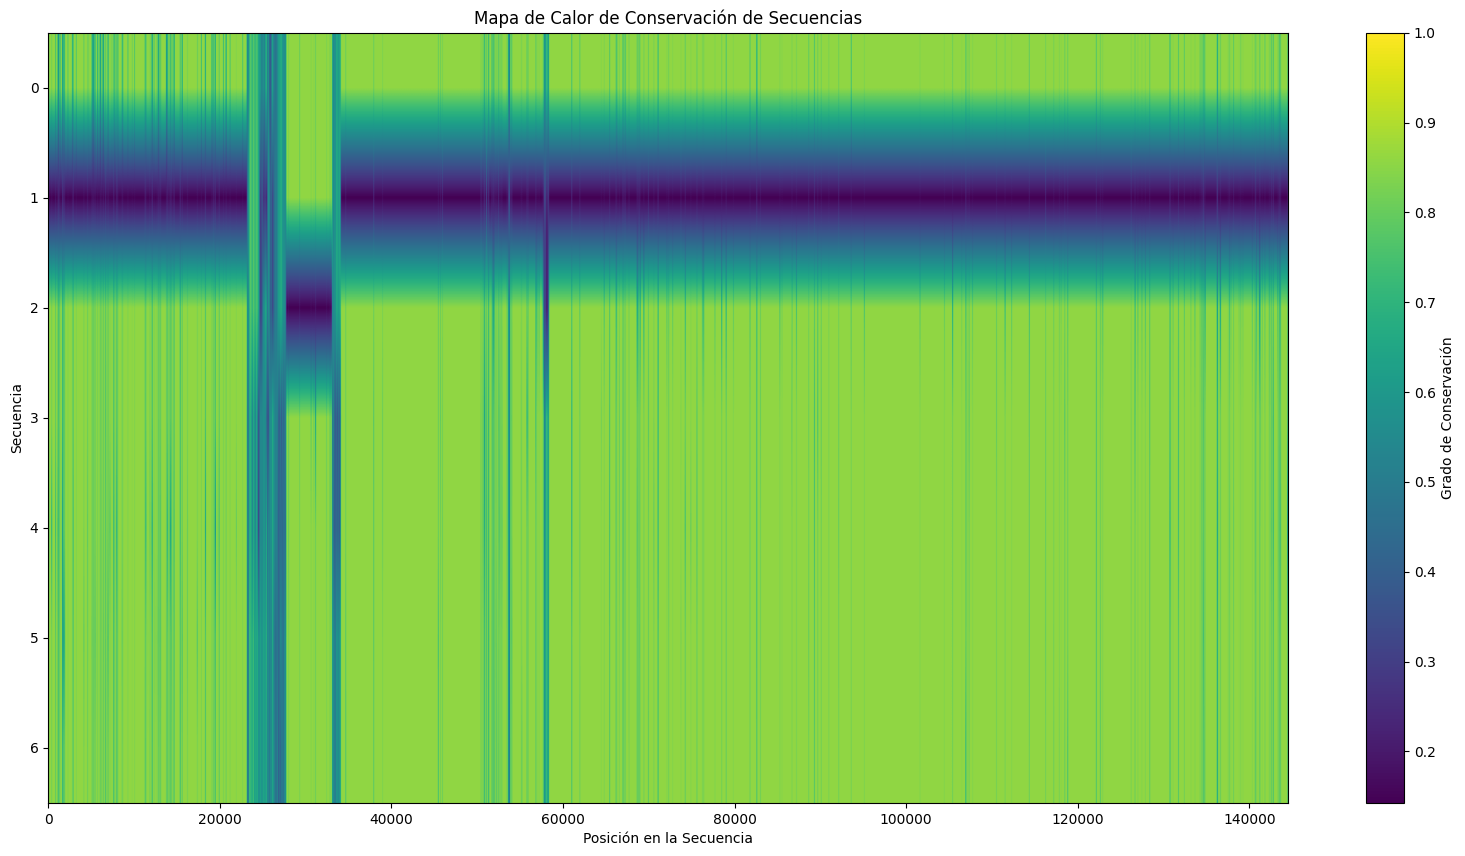

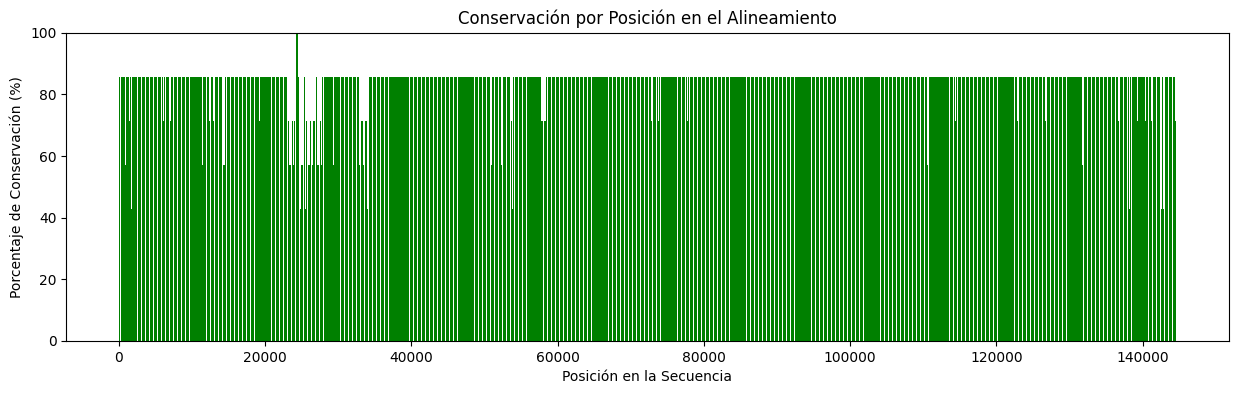

In [41]:
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

# Función para calcular la entropía de cada posición
def calcular_entropia(archivo_alineamiento):
    alineamiento = AlignIO.read(archivo_alineamiento, "fasta")
    longitud = alineamiento.get_alignment_length()
    entropias = np.zeros(longitud)

    for i in range(longitud):
        columna = [record.seq[i] for record in alineamiento]
        entropias[i] = stats.entropy(np.unique(columna, return_counts=True)[1], base=2)

    return entropias

# Función para graficar la entropía
def graficar_entropia(archivo_alineamiento):
    entropias = calcular_entropia(archivo_alineamiento)
    plt.figure(figsize=(12, 4))
    plt.plot(entropias, color='red', lw=2)
    plt.xlabel('Posición en la Secuencia')
    plt.ylabel('Entropía')
    plt.title('Perfil de Entropía del Alineamiento')
    plt.ylim(0, max(entropias))
    plt.show()

def mapa_calor_conservacion(archivo_alineamiento):
    alineamiento = AlignIO.read(archivo_alineamiento, "fasta")
    num_secuencias = len(alineamiento)
    longitud = alineamiento.get_alignment_length()
    matriz_conservacion = np.zeros((num_secuencias, longitud))

    for i, record in enumerate(alineamiento):
        for j in range(longitud):
            matriz_conservacion[i, j] = alineamiento[:, j].count(record.seq[j]) / num_secuencias

    plt.figure(figsize=(20, 10))  # Ajusta el tamaño según sea necesario
    plt.imshow(matriz_conservacion, cmap='viridis', interpolation='bilinear', aspect='auto')
    plt.colorbar(label='Grado de Conservación')
    plt.xlabel('Posición en la Secuencia')
    plt.ylabel('Secuencia')
    plt.title('Mapa de Calor de Conservación de Secuencias')
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
from Bio import AlignIO
from multiprocessing import Pool

def calcular_conservacion_por_posicion(columna, num_secuencias):
    residuo_mas_comun = max(set(columna), key=columna.count)
    conservacion = (columna.count(residuo_mas_comun) / num_secuencias) * 100
    return conservacion

def graficar_barras_conservacion(archivo_alineamiento):
    alineamiento = AlignIO.read(archivo_alineamiento, "fasta")
    num_secuencias = len(alineamiento)
    longitud_secuencia = alineamiento.get_alignment_length()

    # Preparar los datos para el procesamiento en paralelo
    datos = [str(alineamiento[:, i]) for i in range(longitud_secuencia)]

    # Usar multiprocessing para calcular la conservación
    with Pool() as pool:
        porcentajes_conservacion = pool.starmap(calcular_conservacion_por_posicion, [(d, num_secuencias) for d in datos])

    # Graficar la conservación
    plt.figure(figsize=(15, 4))
    plt.bar(range(longitud_secuencia), porcentajes_conservacion, color='green')
    plt.xlabel('Posición en la Secuencia')
    plt.ylabel('Porcentaje de Conservación (%)')
    plt.title('Conservación por Posición en el Alineamiento')
    plt.ylim(0, 100)
    plt.show()

#graficar_entropia('/content/parte_0_alineado.fasta')
#mapa_calor_conservacion('/content/parte_0_alineado.fasta')
#graficar_barras_conservacion('/content/parte_0_alineado.fasta')


<Figure size 1200x400 with 0 Axes>

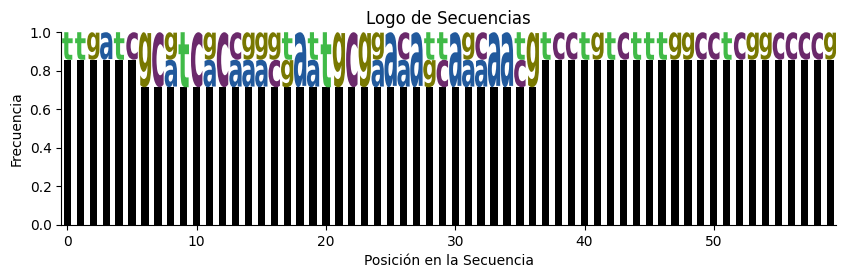

In [98]:
#@title funcion con logomaker

import logomaker
import matplotlib.pyplot as plt
from Bio import AlignIO
import numpy as np
import pandas as pd

def crear_logo_secuencias_logomaker(archivo_alineamiento, segmento=None):
    # Leer el alineamiento
    alineamiento = AlignIO.read(archivo_alineamiento, "fasta")
    if segmento:
        alineamiento = [rec.seq[segmento[0]:segmento[1]] for rec in alineamiento]

    # Convertir a una matriz de NumPy
    aln_array = np.array([list(str(rec)) for rec in alineamiento])

    # Calcular frecuencias
    simbolos = set(aln_array.flatten())
    df_frecuencias = pd.DataFrame({s: (aln_array == s).mean(axis=0) for s in simbolos})

    # Configurar el tamaño de la figura y el espacio entre las columnas
    plt.figure(figsize=(12, 4))
    logo = logomaker.Logo(df_frecuencias, color_scheme='NajafabadiEtAl2017', stack_order='small_on_top')

    # Ajustar la visualización
    logo.ax.set_xlabel('Posición en la Secuencia')
    logo.ax.set_ylabel('Frecuencia')
    logo.ax.set_title('Logo de Secuencias')
    logo.ax.spines['right'].set_visible(False)
    logo.ax.spines['top'].set_visible(False)

    # Mostrar el logo
    plt.show()

# Ejemplo de uso
#crear_logo_secuencias_logomaker('/content/parte_0_alineado.fasta', segmento=(420,480))


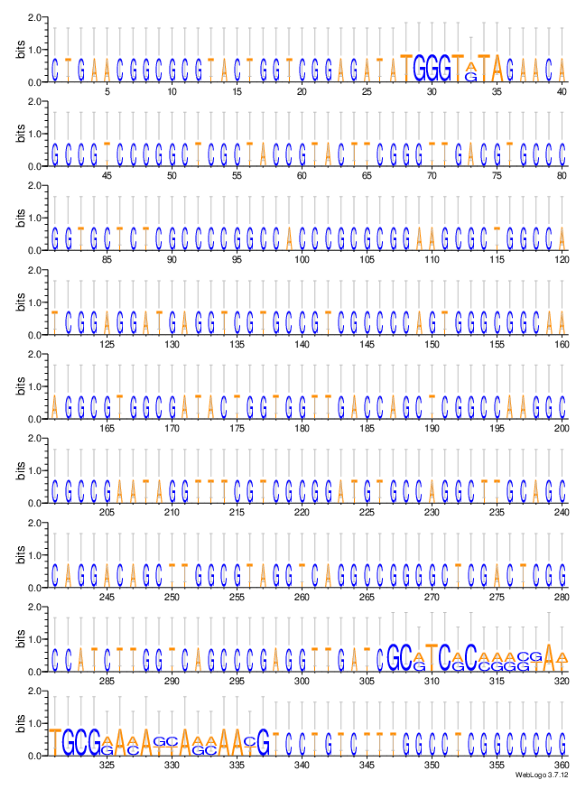

In [96]:
#@title funcion con weblogo
from Bio import AlignIO
import subprocess
import matplotlib.pyplot as plt
import tempfile
import os

def crear_logo_secuencias_weblogo_cli(archivo_alineamiento, segmento=None):
    # Leer el alineamiento
    alineamiento = AlignIO.read(archivo_alineamiento, "fasta")

    # Crear un archivo FASTA temporal para el alineamiento
    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.fasta') as fasta_file:
        fasta_file_name = fasta_file.name
        if segmento:
            for rec in alineamiento:
                fasta_file.write(">" + rec.id + "\n" + str(rec.seq[segmento[0]:segmento[1]]) + "\n")
        else:
            for rec in alineamiento:
                fasta_file.write(">" + rec.id + "\n" + str(rec.seq) + "\n")

    # Crear un archivo temporal para el logo
    temp_logo_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    temp_logo_file_name = temp_logo_file.name
    temp_logo_file.close()

    # Usar WebLogo a través de la línea de comandos para generar el logo
    try:
        subprocess.check_output(["weblogo", "-f", fasta_file_name, "-o", temp_logo_file_name, "--format", "png"], stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        print("Error al generar el logo de secuencias: ", e.output.decode())
        return

    # Mostrar el logo
    try:
        img = plt.imread(temp_logo_file_name)
        plt.figure(figsize=(20, 10))  # Configurar tamaño de la figura
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print("Error al leer el archivo del logo: ", e)

    # Eliminar los archivos temporales
    os.remove(fasta_file_name)
    os.remove(temp_logo_file_name)

# Ejemplo de uso
#crear_logo_secuencias_weblogo_cli('/content/parte_0_alineado.fasta', segmento=(120,480))
